In [258]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_style('darkgrid')

# 1.0 Carregamento dos Dados

In [259]:
tb = pd.read_excel("D:\\Documents\\Projetos\\Morning Star\\Data\\tabela-pocos.xlsx")

In [260]:
tb.head()

,POCO,OPERADOR,ESTADO,BACIA,CAMPO,TERRA_MAR,CATEGORIA,SITUACAO,CONCLUSAO,TITULARIDADE
0,7-TBAZ-1HP-RJS,Dommo Energia,RJ,Campos,TUBARÃO AZUL,M,Desenvolvimento,ABANDONADO PERMANENTEMENTE,2013-01-12,Público
1,3-OGX-50D-RJS,Dommo Energia,RJ,Campos,TUBARÃO AZUL,M,Extensão,ABANDONADO PERMANENTEMENTE,2011-07-24,Público
2,3-OGX-53D-RJS,Dommo Energia,RJ,Campos,TUBARÃO AZUL,M,Extensão,ABANDONADO PERMANENTEMENTE,2011-08-22,Público
3,3-OGX-21D-RJS,Dommo Energia,RJ,Campos,NaN,M,Extensão,ABANDONADO PERMANENTEMENTE,2010-11-26,Público
4,9-OGX-68HP-RJS,Dommo Energia,RJ,Campos,TUBARÃO AZUL,M,Especial,ABANDONADO PERMANENTEMENTE,2012-03-26,Público


# 2.0 Descrição dos Dados

In [261]:
tb.dtypes

POCO                    object
OPERADOR                object
ESTADO                  object
BACIA                   object
CAMPO                   object
TERRA_MAR               object
CATEGORIA               object
SITUACAO                object
CONCLUSAO       datetime64[ns]
TITULARIDADE            object
dtype: object

In [262]:
(tb.isna().sum()/len(tb))*100

POCO             0.000000
OPERADOR         9.785648
ESTADO           0.000000
BACIA            0.000000
CAMPO           15.014645
TERRA_MAR        0.000000
CATEGORIA        0.000000
SITUACAO         2.110238
CONCLUSAO        0.708960
TITULARIDADE     0.000000
dtype: float64

In [263]:
#Achei a orientação de tratamento de valores nulos confusa, portanto, levando em consideração as informações contidas 
#nas colunas que apresentavam linhas nulas, decidi remover todas as linhas nulas visto que não havia possibilidade de identificar 
#parâmetros para completa-las
tb = tb.dropna().reset_index(drop=True)

In [264]:
estado_map = {
    'AC': 'Acre',
    'AL': 'Alagoas',
    'AP': 'Amapá',
    'AM': 'Amazonas',
    'BA': 'Bahia',
    'CE': 'Ceará',
    'DF': 'Distrito Federal',
    'ES': 'Espírito Santo',
    'GO': 'Goiás',
    'MA': 'Maranhão',
    'MT': 'Mato Grosso',
    'MS': 'Mato Grosso do Sul',
    'MG': 'Minas Gerais',
    'PA': 'Pará',
    'PB': 'Paraíba',
    'PR': 'Paraná',
    'PE': 'Pernambuco',
    'PI': 'Piauí',
    'RJ': 'Rio de Janeiro',
    'RN': 'Rio Grande do Norte',
    'RS': 'Rio Grande do Sul',
    'RO': 'Rondônia',
    'RR': 'Roraima',
    'SC': 'Santa Catarina',
    'SP': 'São Paulo',
    'SE': 'Sergipe',
    'TO': 'Tocantins'
}

def mapear_estado(sigla):
    return estado_map.get(sigla, 'Sigla não encontrada')

In [265]:
tb['POCO'] = tb['POCO'].str.replace(r'^.*?-', '', regex=True)

In [266]:
tb['CONCLUSAO'] = tb['CONCLUSAO'].dt.date

In [267]:
tb['PM_MAR'] = tb['TERRA_MAR'].apply(lambda x: 1 if x == 'M' else 0)
tb['PM_TERRA'] = tb['TERRA_MAR'].apply(lambda x: 1 if x == 'T' else 0)

In [268]:
new_columns = ['CD_POCO', 'DS_OPERADOR', 'SG_ESTADO', 'DS_BACIA', 'DS_CAMPO', 'SG_TERRA_MAR','DS_CATEGORIA', 'DS_SITUACAO', 'DT_CONCLUSAO', 'DS_TITULARIDADE', 'PM_MAR','PM_TERRA']

In [269]:
tb.columns = new_columns

In [270]:
tb['DS_ESTADO'] = tb['SG_ESTADO'].apply(mapear_estado)

In [271]:
for column in tb.columns:
    if column.startswith('DS_') == True:
        print(column)
        tb[column] = tb[column].str.title()

DS_OPERADOR
DS_BACIA
DS_CAMPO
DS_CATEGORIA
DS_SITUACAO
DS_TITULARIDADE
DS_ESTADO


In [272]:
tb.to_parquet('Data\\tabela-pocos.parquet', index=False)

# 3.0 Análise Exploratória de Dados

In [273]:
tb.dtypes

CD_POCO            object
DS_OPERADOR        object
SG_ESTADO          object
DS_BACIA           object
DS_CAMPO           object
SG_TERRA_MAR       object
DS_CATEGORIA       object
DS_SITUACAO        object
DT_CONCLUSAO       object
DS_TITULARIDADE    object
PM_MAR              int64
PM_TERRA            int64
DS_ESTADO          object
dtype: object

## 3.1. Gerar Gráficos

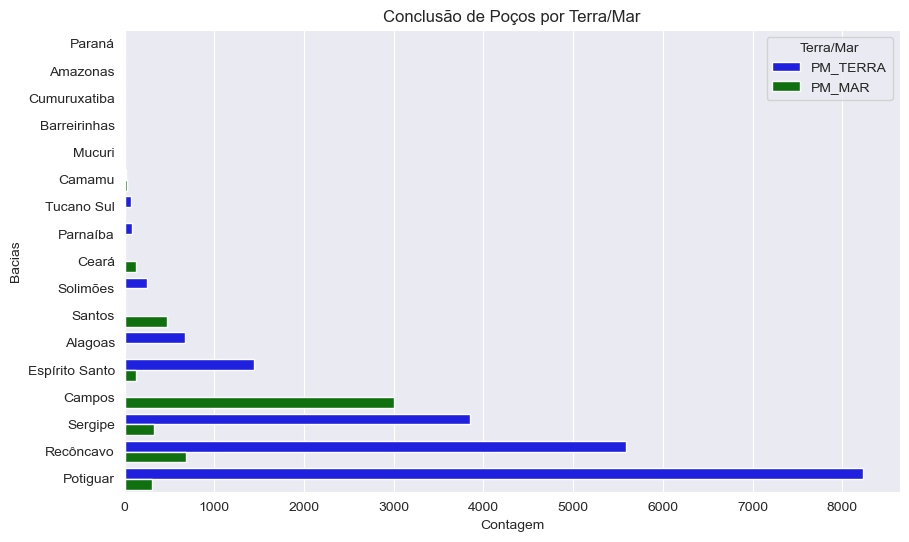

In [274]:
chart1 = tb[['DS_BACIA','DT_CONCLUSAO','PM_MAR','PM_TERRA']].groupby(['DS_BACIA']).agg({'DT_CONCLUSAO': 'count', 'PM_MAR': 'sum', 'PM_TERRA': 'sum'}).sort_values(by='DT_CONCLUSAO').reset_index()

chart1_melted = chart1[['DS_BACIA','PM_TERRA','PM_MAR']].melt(id_vars=['DS_BACIA'], var_name='Tipo', value_name='Valor')
chart1_melted

plt.figure(figsize=(10, 6))
sns.barplot(data=chart1_melted, x='Valor', y='DS_BACIA', hue='Tipo', palette=['blue', 'green'])

#for index, value in enumerate(chart1_melted[chart1_melted['Tipo'] == 'PM_MAR']['Valor']):
#    plt.annotate(f'{value}', xy=(value, index+0.10), ha='left', va='top', fontsize=8, color='green')
#
#for index, value in enumerate(chart1_melted[chart1_melted['Tipo'] == 'PM_TERRA']['Valor']):
#    plt.annotate(f'{value}', xy=(value, index+0.05), ha='left', va='bottom', fontsize=8, color='blue')
    
plt.legend(title='Terra/Mar')
plt.xlabel('Contagem')
plt.ylabel('Bacias')
plt.title('Conclusão de Poços por Terra/Mar')

plt.show()

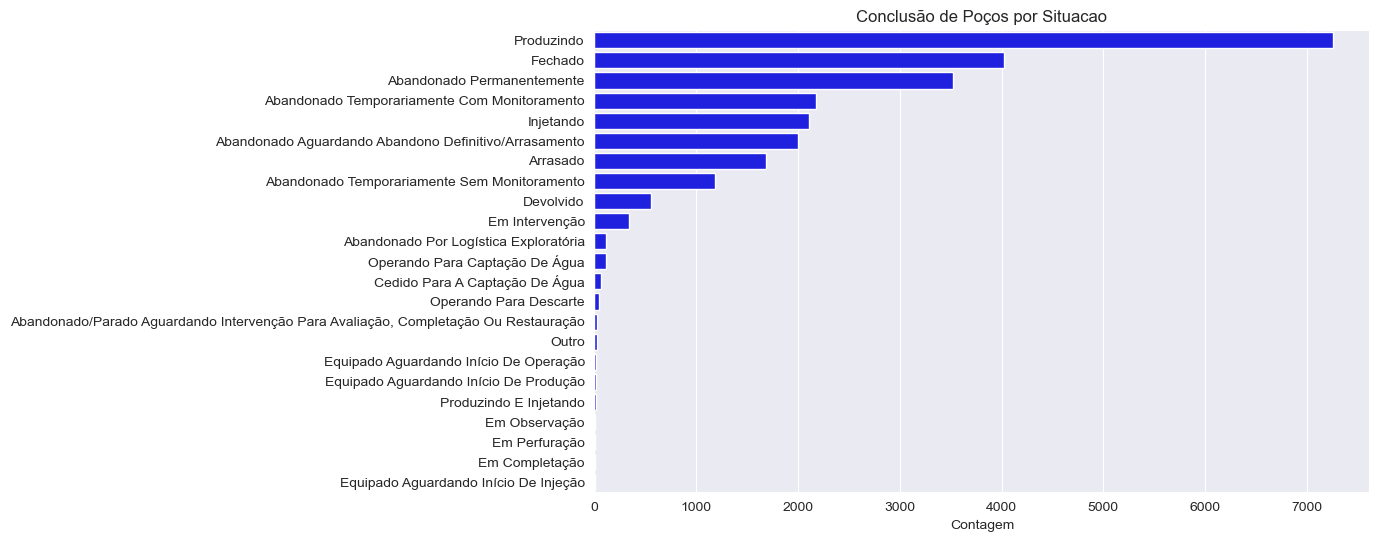

In [275]:
chart2 = tb[['DS_SITUACAO','DT_CONCLUSAO']].groupby(['DS_SITUACAO']).agg({'DT_CONCLUSAO': 'count'}).sort_values(by='DT_CONCLUSAO', ascending=False).reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=chart2, x='DT_CONCLUSAO', y='DS_SITUACAO', palette=['blue'])

plt.xlabel('Contagem')
plt.ylabel('')
plt.title('Conclusão de Poços por Situacao')

plt.show()

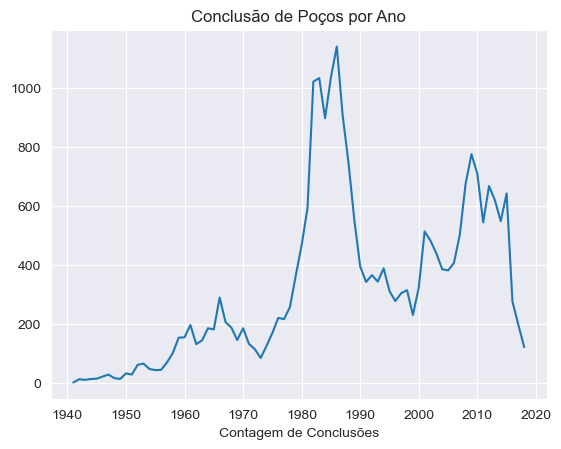

In [276]:
tb['DT_YEAR'] = pd.to_datetime(tb['DT_CONCLUSAO']).dt.year
chart3 = tb[['DT_YEAR','DT_CONCLUSAO']].groupby(['DT_YEAR']).agg({'DT_CONCLUSAO': 'count'}).reset_index()

sns.lineplot(data=chart3, x='DT_YEAR', y='DT_CONCLUSAO')

plt.xlabel('Contagem de Conclusões')
plt.ylabel('')
plt.title('Conclusão de Poços por Ano')

plt.show()

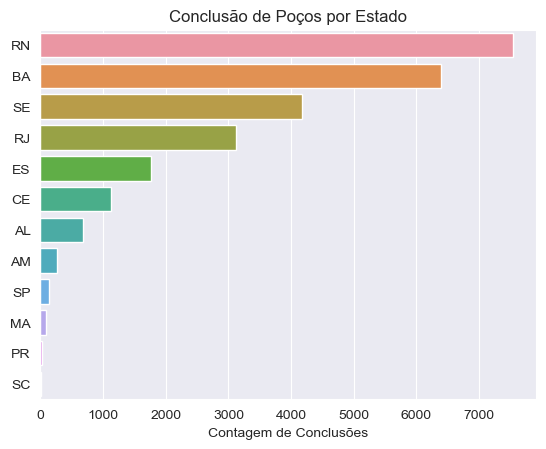

In [277]:
chart4 = tb[['SG_ESTADO','DT_CONCLUSAO']].groupby(['SG_ESTADO']).agg({'DT_CONCLUSAO': 'count'}).reset_index().sort_values(by='DT_CONCLUSAO', ascending=False)

sns.barplot(data=chart4, x='DT_CONCLUSAO', y='SG_ESTADO')

plt.xlabel('Contagem de Conclusões')
plt.ylabel('')
plt.title('Conclusão de Poços por Estado')

plt.show()

## 3.2 Plotar gráficos no Canvas

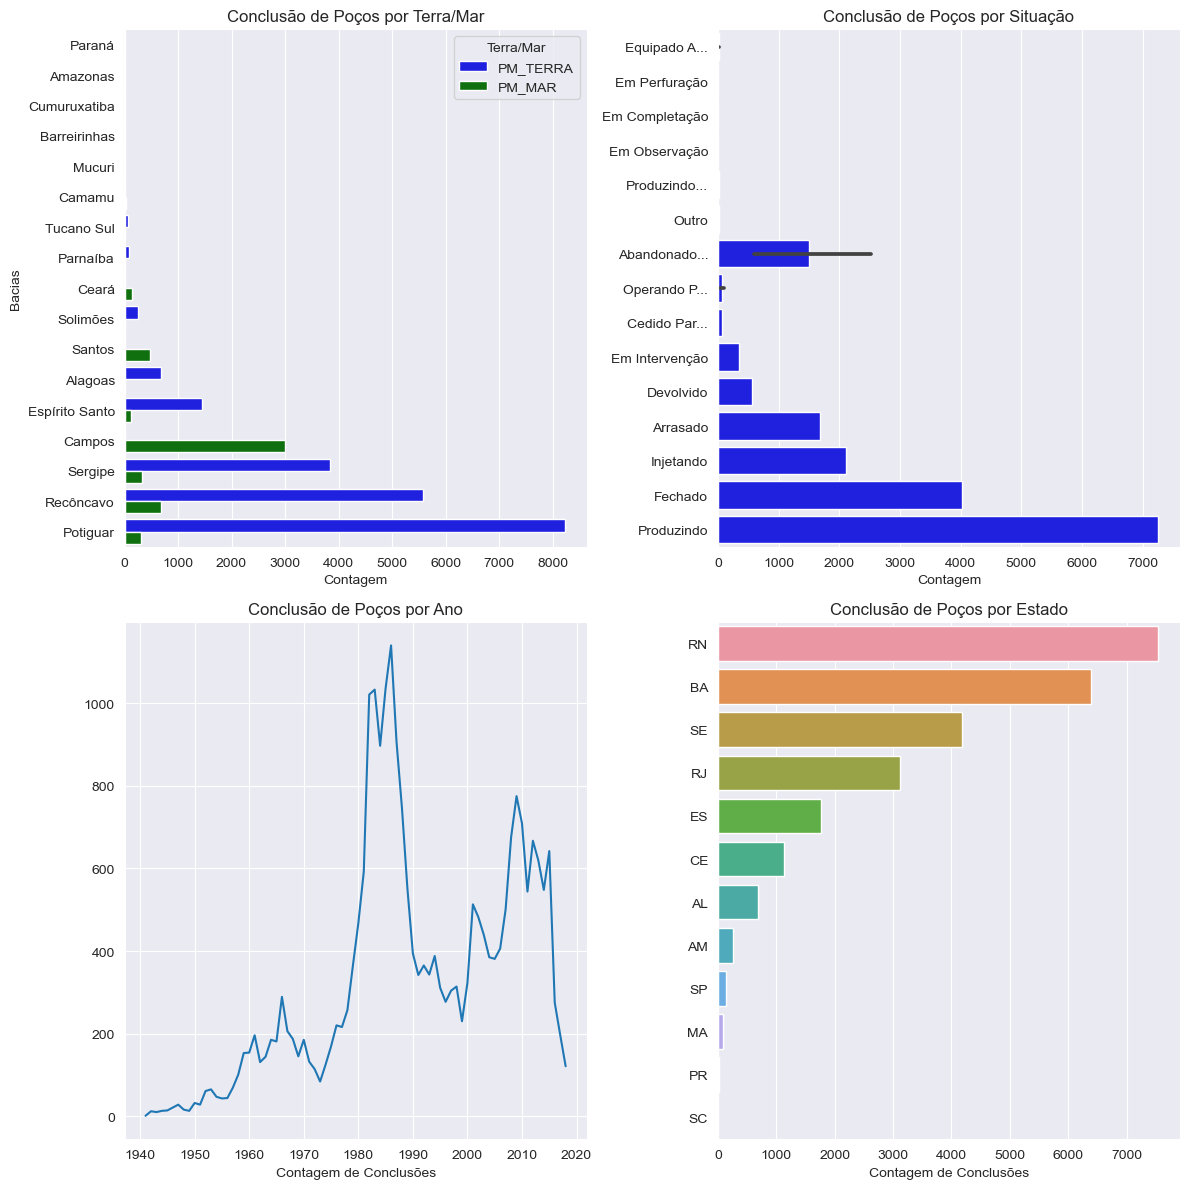

In [278]:
chart1 = tb[['DS_BACIA','DT_CONCLUSAO','PM_MAR','PM_TERRA']].groupby(['DS_BACIA']).agg({'DT_CONCLUSAO': 'count', 'PM_MAR': 'sum', 'PM_TERRA': 'sum'}).sort_values(by='DT_CONCLUSAO').reset_index()
chart1_melted = chart1[['DS_BACIA','PM_TERRA','PM_MAR']].melt(id_vars=['DS_BACIA'], var_name='Tipo', value_name='Valor')

chart2 = tb[['DS_SITUACAO','DT_CONCLUSAO']].groupby(['DS_SITUACAO']).agg({'DT_CONCLUSAO': 'count'}).sort_values(by='DT_CONCLUSAO').reset_index()
chart2['DS_SITUACAO'] = chart2['DS_SITUACAO'].apply(lambda x: x[:10] + '...' if len(x) > 20 else x)

tb['DT_YEAR'] = pd.to_datetime(tb['DT_CONCLUSAO']).dt.year
chart3 = tb[['DT_YEAR','DT_CONCLUSAO']].groupby(['DT_YEAR']).agg({'DT_CONCLUSAO': 'count'}).reset_index()

plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
sns.barplot(data=chart1_melted, x='Valor', y='DS_BACIA', hue='Tipo', palette=['blue', 'green'])
plt.legend(title='Terra/Mar')
plt.xlabel('Contagem')
plt.ylabel('Bacias')
plt.title('Conclusão de Poços por Terra/Mar')

plt.subplot(2, 2, 2)
sns.barplot(data=chart2, x='DT_CONCLUSAO', y='DS_SITUACAO', palette=['blue'])
plt.xlabel('Contagem')
plt.ylabel('')
plt.title('Conclusão de Poços por Situação')

plt.subplot(2, 2, 3)
sns.lineplot(data=chart3, x='DT_YEAR', y='DT_CONCLUSAO')
plt.xlabel('Contagem de Conclusões')
plt.ylabel('')
plt.title('Conclusão de Poços por Ano')

plt.subplot(2, 2, 4)
sns.barplot(data=chart4, x='DT_CONCLUSAO', y='SG_ESTADO')
plt.xlabel('Contagem de Conclusões')
plt.ylabel('')
plt.title('Conclusão de Poços por Estado')

plt.tight_layout()
plt.show()